# Disaster Tweet Classifaction 

## Introduction

When a disaster occurs, Twitter becomes a useful tool for anyone needing to stay up to date with any developments. This is due to the ubuiquitosness of smartphones, which enables more people to communicate in real-time, and allow for many more detection points for disaters. Many organizations rely on this data to mobilize first responders and disater relief. While it can be a useful tool in monitoring for disaters, we need the ability to detect whether a tweet is genuinely about a disater.

This notebook will utilize two deep learning appraches LTSM and GRU and compare their ability to detect whether a tweet is about a real disaster.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
2025-07-23 21:50:15.921746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753307416.107450      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753307416.159992      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

## Exploratory Data Analysis

Once we load the training data, we'll perform some EDA to see what kind of data we are working with and what sort of pre-processing we might need to do for model training. 

In [4]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [7]:
sample_submission.head(10)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


We'll look at the length of each tweet. To do this, we will add a column to our train dataset. 

Text(0, 0.5, 'Frequency')

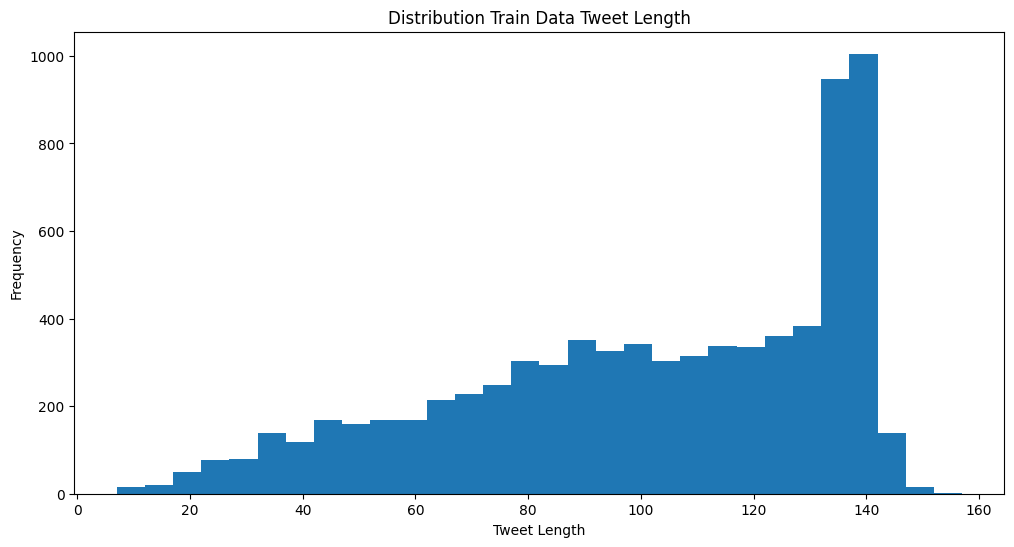

In [8]:
train_df["length"] = train_df["text"].apply(lambda x: len(x) if pd.notnull(x) else 0)

plt.figure(figsize=(12, 6))

plt.hist(train_df["length"], bins = 30)
plt.title('Distribution Train Data Tweet Length')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

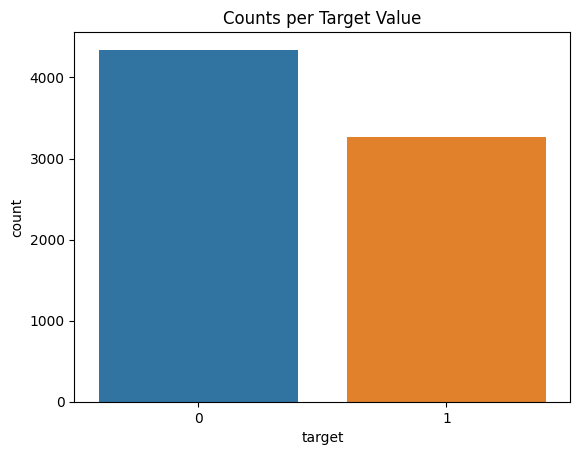

In [9]:
sns.countplot(data=train_df, x='target').set(title='Counts per Target Value');

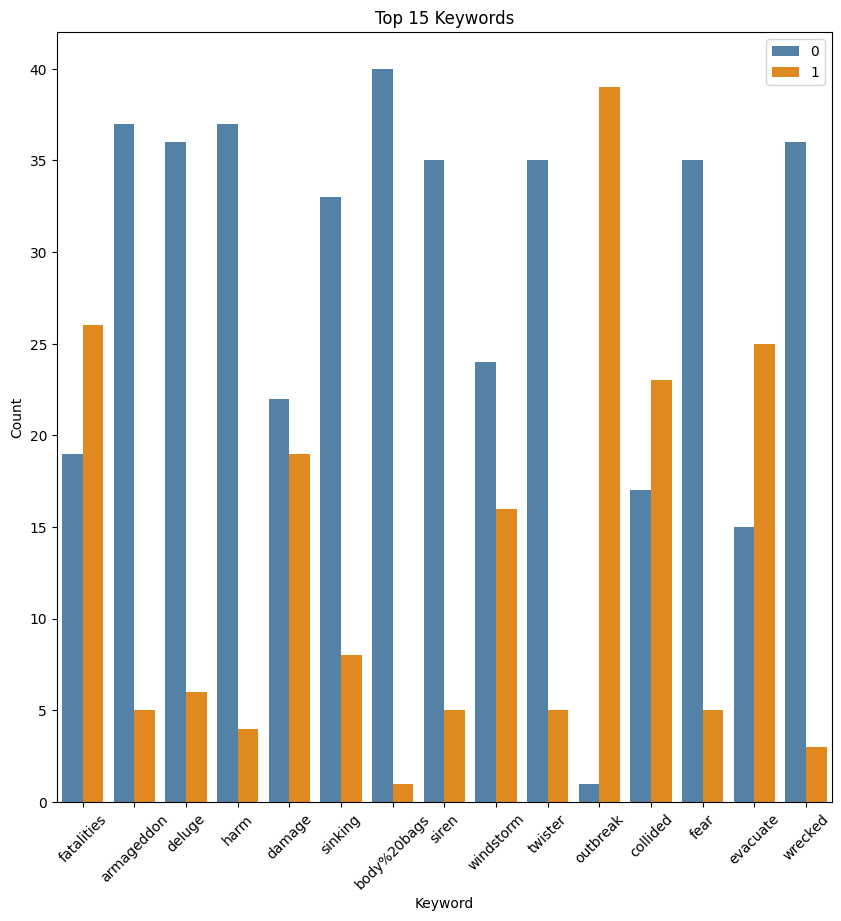

In [10]:
#plot distribution of top 15 keywords
plt.figure(figsize=[10, 10])

sns.countplot(x='keyword', 
              data=train_df,
              order=train_df['keyword'].value_counts()[:15].index,
              hue='target',
              palette=['steelblue', 'darkorange']).set(title='Top 15 Keywords', 
                                                      ylabel='Count',
                                                      xlabel='Keyword')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show();

As we can see in the plot above, some keywords only really appear in fake disaster tweets, while "outbreak" only really appear in real disaster tweets.

## Data Preprocessing

There are lots of symbols, so we will construct a helper class to remove punctuation and special charaters. The helper function will also make all words lowercase and also lematize the text. Lematization is the process of removing the endings of words. [1]

In [11]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase the text
    text = text.lower()
    # Lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


train_df['text'] = train_df['text'].apply(preprocess_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_df['text'])

## Modeling

We'll examine two approaches. One utilizing LSTM and the other utilizing GRU. We'll split our training data into a train and test set so that we have labeled output to analyze our model performance.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, train_df['target'], test_size=0.2, random_state=42)

### LTSM Approach

I0000 00:00:1753307432.299654      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753307432.300304      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


I0000 00:00:1753307437.522196     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5852 - auc: 0.6610 - loss: 0.6750 - val_accuracy: 0.7085 - val_auc: 0.8444 - val_loss: 0.5895
Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8156 - auc: 0.9308 - loss: 0.4981 - val_accuracy: 0.7931 - val_auc: 0.8561 - val_loss: 0.4683
Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9112 - auc: 0.9658 - loss: 0.3010 - val_accuracy: 0.8030 - val_auc: 0.8581 - val_loss: 0.4523
Epoch 4/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9490 - auc: 0.9866 - loss: 0.1797 - val_accuracy: 0.7964 - val_auc: 0.8543 - val_loss: 0.4747
Epoch 5/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9730 - auc: 0.9966 - loss: 0.1034 - val_accuracy: 0.7849 - val_auc: 0.8500 - val_loss: 0.5066
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


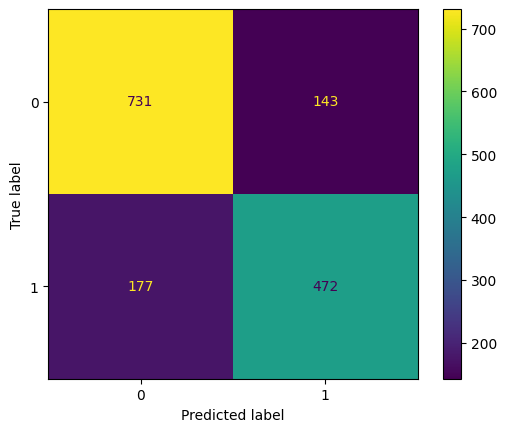

,Model,Precision,Recall,F1-score
0,LTSM,0.789049,0.789888,0.789067


In [13]:
# Reshape the input data for LSTM
X_train_lstm = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.toarray().reshape(X_test.shape[0], 1, X_test.shape[1])


# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','auc'])

# Train the model
model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, validation_split=0.2)


# Predict on the test set
y_pred_prob = model.predict(X_test_lstm)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)

# Precision, Recall, F1-score to a table
model_results = pd.DataFrame({
    'Model': ['LTSM'],
    'Precision': [report['weighted avg']['precision']],
    'Recall': [report['weighted avg']['recall']],
    'F1-score': [report['weighted avg']['f1-score']]
})

model_results

In [14]:
type(X_train)

scipy.sparse._csr.csr_matrix

## GRU Approach

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 64)                  │       4,114,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,115,009 (15.70 MB)

 Trainable params: 4,115,009 (15.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5935 - auc: 0.6704 - loss: 0.6641 - val_accuracy: 0.7783 - val_auc: 0.8513 - val_loss: 0.5453
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8647 - auc: 0.9404 - loss: 0.4301 - val_accuracy: 0.7997 - val_auc: 0.8578 - val_loss: 0.4546
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9371 - auc: 0.9818 - loss: 0.2291 - val_accuracy: 0.8021 - val_auc: 0.8569 - val_loss: 0.4595
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9678 - auc: 0.9945 - loss: 0.1337 - val_accuracy: 0.7882 - val_auc: 0.8520 - val_loss: 0.4881
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9820 - auc: 0.9982 - loss: 0.0805 - val_accuracy: 0.7742 - val_auc: 0.8470 - val_loss: 0.5224
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9883 - auc: 0.9995 - loss: 0.0534 - val_accuracy: 0.7791 - val_auc: 0.8429 - val_loss: 0.5573
Epoch 7/30
153/153 ━━━━━━━━━━━━━━━━━━━━

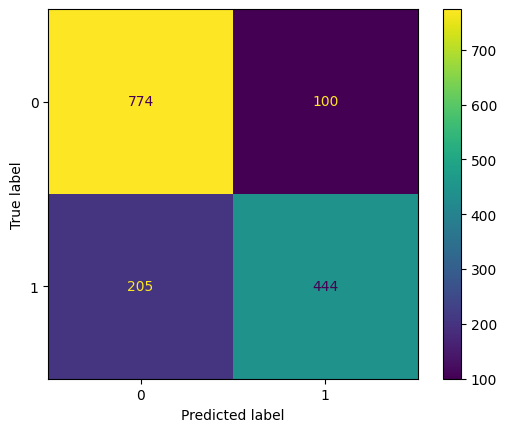

In [15]:
# Reshape the input data for GRU
X_train_gru = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_gru = X_test.toarray().reshape(X_test.shape[0], 1, X_test.shape[1])


#simple GRU Model
gru_model_simple = Sequential()
gru_model_simple.add(GRU(64, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
gru_model_simple.add(Dense(1, activation='sigmoid'))
gru_model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'auc'])

gru_model_simple.summary()

es_gru = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train GRU model
gru_model_simple.fit(X_train_gru, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[es_gru])

# Predict on the test set using the GRU model
y_pred_prob_gru_simple = gru_model_simple.predict(X_test_gru)
y_pred_gru_simple = (y_pred_prob_gru_simple > 0.5).astype(int)

# Confusion Matrix for GRU
cm_gru = confusion_matrix(y_test, y_pred_gru_simple)
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru)
disp_gru.plot()
plt.show()

# Classification Report for GRU
from sklearn.metrics import classification_report
report_gru = classification_report(y_test, y_pred_gru_simple, output_dict=True)
# Append GRU results to the model_results DataFrame
new_row = pd.DataFrame({
    'Model': ['GRU-simple'],
    'Precision': [report_gru['weighted avg']['precision']],
    'Recall': [report_gru['weighted avg']['recall']],
    'F1-score': [report_gru['weighted avg']['f1-score']]
})
model_results = pd.concat([model_results, new_row], ignore_index=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 1, 64)               │       4,114,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,125,441 (15.74 MB)

 Trainable params: 4,125,441 (15.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5762 - auc: 0.5990 - loss: 0.6666 - val_accuracy: 0.8005 - val_auc: 0.8549 - val_loss: 0.4536
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8856 - auc: 0.9444 - loss: 0.2914 - val_accuracy: 0.7841 - val_auc: 0.8482 - val_loss: 0.4971
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9656 - auc: 0.9923 - loss: 0.1135 - val_accuracy: 0.7767 - val_auc: 0.8399 - val_loss: 0.6150
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9839 - auc: 0.9973 - loss: 0.0533 - val_accuracy: 0.7644 - val_auc: 0.8314 - val_loss: 0.7504
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9903 - auc: 0.9993 - loss: 0.0302 - val_accuracy: 0.7422 - val_auc: 0.8247 - val_loss: 0.8922
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9946 - auc: 0.9998 - loss: 0.0163 - val_accuracy: 0.7586 - val_auc: 0.8233 - val_loss: 0.9061
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

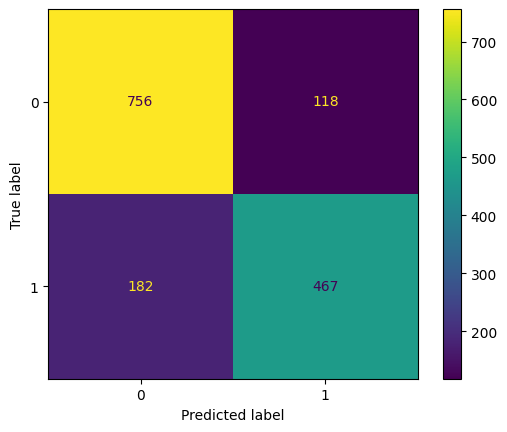

In [16]:
# Build GRU model
gru_model = Sequential()
gru_model.add(GRU(64, return_sequences=True, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(32))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(32, activation='relu'))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'auc'])

gru_model.summary()

# Train GRU model
gru_model.fit(X_train_gru, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[es_gru])

# Predict on the test set using the GRU model
y_pred_prob_gru = gru_model.predict(X_test_gru)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

# Confusion Matrix for GRU
cm_gru = confusion_matrix(y_test, y_pred_gru)
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru)
disp_gru.plot()
plt.show()


# Append GRU results to the model_results DataFrame
report_gru = classification_report(y_test, y_pred_gru, output_dict=True)
new_row = pd.DataFrame({
    'Model': ['GRU'],
    'Precision': [report_gru['weighted avg']['precision']],
    'Recall': [report_gru['weighted avg']['recall']],
    'F1-score': [report_gru['weighted avg']['f1-score']]
})
model_results = pd.concat([model_results, new_row], ignore_index=True)

## Analysis

In [17]:
model_results

,Model,Precision,Recall,F1-score
0,LTSM,0.789049,0.789888,0.789067
1,GRU-simple,0.801500,0.799737,0.796598
2,GRU,0.802698,0.803020,0.801391


Here we see near identical performance from the two approaches. Let's see how it does with the test data. We'll start by pre-processing the data using our previously defined helper function.

In [18]:
test_df['text'] = test_df['text'].apply(preprocess_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
submit_X = vectorizer.fit_transform(test_df['text'])

In [19]:
submit_X.shape

(3263, 11948)

In [20]:
#LTSM Approach
#submit_X_ltsm = submit_X.toarray().reshape(submit_X.shape[0], 1, submit_X.shape[1])
#submit_y_prob = model.predict(submit_X_ltsm)

#GRU Approach
submit_X_gru = submit_X.toarray().reshape(submit_X.shape[0], 1, submit_X.shape[1])
submit_y_prob = gru_model.predict(submit_X_gru)

submit_y = (submit_y_prob > 0.5).astype(int).flatten()


print(submit_y[1:10])

submission = pd.DataFrame({'id':test_df['id'], 'target':submit_y})

submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[0 0 0 0 0 0 0 0 0]


**LTSM Score: 0.56205**

**GRU (Simple model) Score: 0. 55776**

**GRU (complex model) Score: 0.49524**

Although the models had performed better in training roughly a .78 to .8 accuracy and recall, they performed about as well as a coinflip with the test submission data. This may have occured for several reasons. The data could have been cleaned better, using TF-IDF may not have been the optimal choice for encoding, our choice in LTSM and GRU models may have not been the correct choice. It is also possible that these models were the correct choice, just the hyperparameters could have been chosen better. 


## Conclusion
To summarize, first we performed some EDA to understand the data we were looking at. Then we cleaned the text by removing special charachters, makeing all letters lowercase, and lemmatizing. We split the data in to a training and validation set, and trained LSTM and GRU models. Model performance was evaluated using the validation set and the Kaggle competion score. Both models in this case performed okay with the validation data, but not that well with the competition data. Areas to look in to for future iterations of this notebook would be different methods of processing text, perhaps TF-IDF was not the optimal choice, or try different model architectures. Ideally we would test each independently to figure out the optimal configuration.

## References

* [1] Lematization - https://www.geeksforgeeks.org/python/python-lemmatization-with-nltk/
* [2] NLTK - https://www.geeksforgeeks.org/python/NLTK-NLP/
